In [ ]:
pip install torchmetrics torchview

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchmetrics import Accuracy
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import logging

In [ ]:
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[
        logging.FileHandler("training.log"),
        logging.StreamHandler()
    ],
    force=True
)

In [ ]:
dataset_path = "/content/drive/MyDrive"
name_model_list = ["VGG16", "ResNet18", "DenseNet121", "EfficientNet_B0"]

In [ ]:
class Model:
    def __init__(self, name_model, num_classes, pretrained, freeze_backbone):
        self.num_classes = num_classes
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.accuracy = Accuracy(task="multiclass", num_classes=num_classes).to(self.device)

        if name_model == "VGG16":
            self.model = torchvision.models.vgg16(
                weights="IMAGENET1K_V1" if pretrained else None
            )
            in_features = self.model.classifier[6].in_features
            self.model.classifier[6] = nn.Linear(in_features, num_classes)
            self.classifier = self.model.classifier[6]

        elif name_model == "ResNet18":
            self.model = torchvision.models.resnet18(
                weights="IMAGENET1K_V1" if pretrained else None
            )
            in_features = self.model.fc.in_features
            self.model.fc = nn.Linear(in_features, num_classes)
            self.classifier = self.model.fc

        elif name_model == "DenseNet121":
            self.model = torchvision.models.densenet121(
                weights="IMAGENET1K_V1" if pretrained else None
            )
            in_features = self.model.classifier.in_features
            self.model.classifier = nn.Linear(in_features, num_classes)
            self.classifier = self.model.classifier

        elif name_model == "EfficientNet_B0":
            self.model = torchvision.models.efficientnet_b0(
                weights="IMAGENET1K_V1" if pretrained else None
            )
            in_features = self.model.classifier[1].in_features
            self.model.classifier[1] = nn.Linear(in_features, num_classes)
            self.classifier = self.model.classifier[1]

        else:
            raise ValueError("Invalid model name")

        logging.info(f"Created {name_model} with {num_classes} output classes")
        self.model.to(self.device)

        if freeze_backbone:
            for param in self.model.parameters():
                param.requires_grad = False
            for param in self.classifier.parameters():
                param.requires_grad = True
            logging.info(f"With frozen learning for {name_model}")
        else:
            logging.info(f"Without frozen learning for {name_model}")

    def train_model(self, dataloader, criterion, optimizer, epochs):
        loss_list = []
        accuracy_list = []

        for epoch in range(epochs):
            self.model.train()
            train_loss = 0.0
            self.accuracy.reset()

            for inputs, labels in dataloader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                self.accuracy.update(outputs, labels)

            epoch_loss = train_loss / len(dataloader)
            epoch_acc = self.accuracy.compute().item()

            loss_list.append(epoch_loss)
            accuracy_list.append(epoch_acc)
            logging.info(f"Epoch {epoch + 1}/{epochs} Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}")

        return loss_list, accuracy_list

    def evaluate_model(self, dataloader, criterion):
        self.model.eval()
        loss_total = 0.0
        self.accuracy.reset()

        with torch.no_grad():
            for inputs, labels in dataloader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                loss_total += criterion(outputs, labels).item()
                self.accuracy.update(outputs, labels)

        test_acc = self.accuracy.compute().item()
        return loss_total / len(dataloader), test_acc

In [ ]:
class DatasetManager:
    def __init__(self, data_root, batch_size=64, num_workers=2):
        self.data_root = data_root
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.train_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.RandomRotation(10),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            transforms.RandomGrayscale(p=0.1),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

        self.test_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    def load_cifar10(self):
        trainset = torchvision.datasets.CIFAR10(root=self.data_root, train=True, download=False, transform=self.train_transform)
        testset = torchvision.datasets.CIFAR10(root=self.data_root, train=False, download=False, transform=self.test_transform)

        trainloader = DataLoader(trainset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)
        testloader = DataLoader(testset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)
        classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

        return trainloader, testloader, classes

In [ ]:
class Visualizer:
    @staticmethod
    def plot_history(train_loss, train_acc):
        epochs = range(1, len(train_loss) + 1)
        plt.figure(figsize=(14, 5))

        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_loss, 'b-', label='Train Loss', linewidth=2)
        plt.title('Training Loss over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.subplot(1, 2, 2)
        plt.plot(epochs, train_acc, 'b-', label='Train Accuracy', linewidth=2)
        plt.title('Training Accuracy over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_freeze_comparison(results, model_names, save_path="freeze_compare.png"):
        frozen = {}
        unfrozen = {}
        for model in results:
            name = model["Model"]
            acc = model["Test Accuracy"]
            if model["Freeze Backbone"]:
                frozen[name] = acc
            else:
                unfrozen[name] = acc

        frozen_acc = [frozen[m] for m in model_names]
        unfrozen_acc = [unfrozen[m] for m in model_names]
        x = range(len(model_names))

        plt.figure(figsize=(10, 6))
        plt.bar([i - 0.2 for i in x], frozen_acc, width=0.4, label='Frozen Backbone')
        plt.bar([i + 0.2 for i in x], unfrozen_acc, width=0.4, label='Unfrozen Backbone')

        plt.xticks(x, model_names)
        plt.ylabel("Test Accuracy")
        plt.title("Comparison: Frozen vs Unfrozen Backbone")
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.6)

        plt.tight_layout()
        plt.savefig(save_path)
        logging.info(f"Comparison plot saved as '{save_path}'")
        plt.show()

In [ ]:
class TransferLearningManager:
    def __init__(self, data_root):
        self.data = DatasetManager(data_root)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.best_accuracy = 0

    def train_and_evaluate_model(self, name_model, epochs, pretrained, freeze_backbone, save_path="model.pth"):
        trainloader, testloader, classes = self.data.load_cifar10()

        model = Model(name_model, len(classes), pretrained=pretrained, freeze_backbone=freeze_backbone)
        model.model.to(self.device)
        criterion = nn.CrossEntropyLoss()
        if freeze_backbone:
            optimizer = optim.AdamW(model.classifier.parameters(),lr=1e-5, weight_decay=1e-4)
        else:
            optimizer = optim.AdamW(model.model.parameters(), lr=1e-5, weight_decay=1e-4)

        logging.info(f"Error function: {criterion}")
        logging.info(f"Optimizer: {optimizer}")

        train_loss_list, train_acc_list = model.train_model(trainloader, criterion, optimizer, epochs=epochs)
        test_loss, test_acc = model.evaluate_model(testloader, criterion)
        logging.info(f"Test Loss {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

        if test_acc > self.best_accuracy:
            self.best_accuracy = test_acc
            torch.save(model.model.state_dict(), save_path)

        Visualizer.plot_history(train_loss_list, train_acc_list)
        return {"Model": name_model, "Test Accuracy": test_acc,"Freeze Backbone": freeze_backbone,
                  "Error function": criterion, "Optimizer": optimizer, "Epochs": epochs}

    def log_best_model(self, results):
        if results is None: return

        best_model = None
        best_acc = 0.0
        for model in results:
            if best_acc < model["Test Accuracy"]:
                best_acc = model["Test Accuracy"]
                best_model = model

        logging.info(f"Best Model: {best_model['Model']}")
        logging.info(f"Best Test Accuracy: {best_model['Test Accuracy']:.4f}")
        logging.info(f"Freeze Backbone: {best_model['Freeze Backbone']}")
        logging.info(f"Optimizer: {best_model['Optimizer']}")
        logging.info(f"Error function: {best_model['Error function']}")
        logging.info(f"Epochs: {best_model['Epochs']}")

    def execute_model_comparison(self, name_model_list, epochs, save_model="best_model.pth"):
        logging.info(f"New launch")
        logging.info(f"Device: {self.device}")

        study_results = []
        for name in name_model_list:
            study_results.append(self.train_and_evaluate_model(name, epochs=epochs, pretrained=True,
                                                                    freeze_backbone=True, save_path=save_model))
            study_results.append(self.train_and_evaluate_model(name, epochs=epochs, pretrained=True,
                                                                    freeze_backbone=False, save_path=save_model))

        Visualizer.plot_freeze_comparison(study_results, name_model_list)
        self.log_best_model(study_results)
        if study_results is not None:
            logging.info(f"Best Model saved as '{save_model}'")

2025-11-19 08:10:16,838 - INFO - New launch
2025-11-19 08:10:16,839 - INFO - Device: cuda


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:06<00:00, 83.1MB/s]
2025-11-19 08:10:45,380 - INFO - Created VGG16 with 10 output classes
2025-11-19 08:10:45,518 - INFO - With frozen learning for VGG16
2025-11-19 08:10:45,520 - INFO - Error function: CrossEntropyLoss()
2025-11-19 08:10:45,521 - INFO - Optimizer: AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: True
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 1e-05
    maximize: False
    weight_decay: 0.0001
)
2025-11-19 08:11:43,700 - INFO - Epoch 1/20 Train Loss: 2.2132, Train Acc: 0.2016
2025-11-19 08:12:42,165 - INFO - Epoch 2/20 Train Loss: 1.9386, Train Acc: 0.3023
2025-11-19 08:13:40,662 - INFO - Epoch 3/20 Train Loss: 1.8414, Train Acc: 0.3366
2025-11-19 08:14:39,606 - INFO - Epoch 4/20 Train Loss: 1.7803, Train Acc: 0.3607
2025-11-19 08:15:38,210 - INFO - Epoch 5/20 Train Loss: 1.7461, Train Acc: 0.3706
2025-11-19 08:16:36,620 - INFO - 

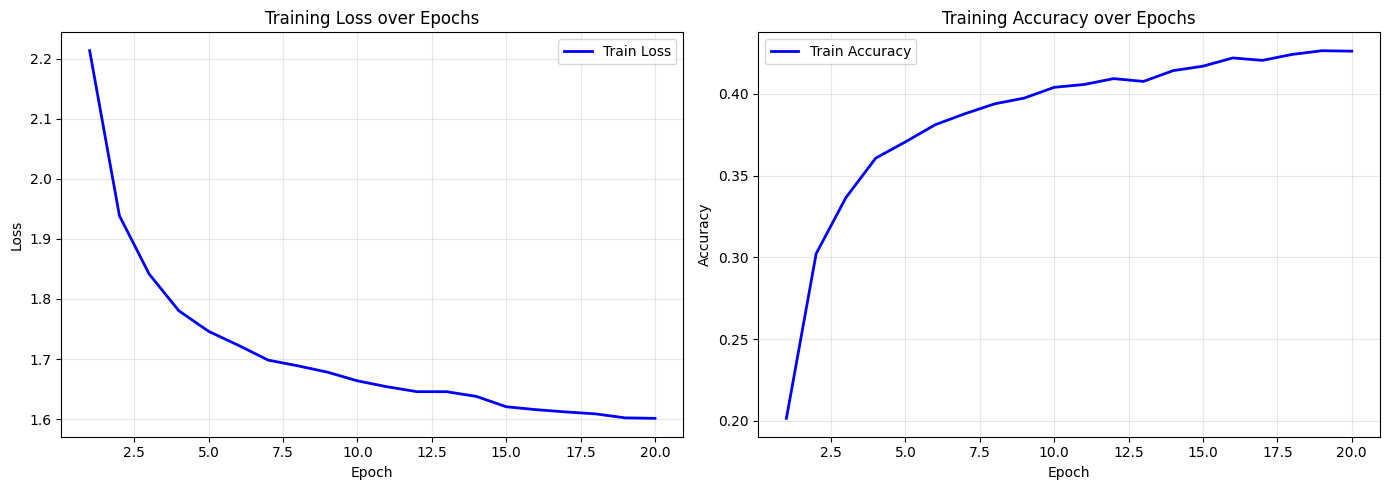

2025-11-19 08:30:23,369 - INFO - Created VGG16 with 10 output classes
2025-11-19 08:30:23,545 - INFO - Without frozen learning for VGG16
2025-11-19 08:30:23,547 - INFO - Error function: CrossEntropyLoss()
2025-11-19 08:30:23,551 - INFO - Optimizer: AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: True
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 1e-05
    maximize: False
    weight_decay: 0.0001
)
2025-11-19 08:31:39,279 - INFO - Epoch 1/20 Train Loss: 1.3464, Train Acc: 0.5195
2025-11-19 08:32:54,425 - INFO - Epoch 2/20 Train Loss: 0.9291, Train Acc: 0.6762
2025-11-19 08:34:10,278 - INFO - Epoch 3/20 Train Loss: 0.8079, Train Acc: 0.7199
2025-11-19 08:35:26,146 - INFO - Epoch 4/20 Train Loss: 0.7327, Train Acc: 0.7460
2025-11-19 08:36:41,344 - INFO - Epoch 5/20 Train Loss: 0.6834, Train Acc: 0.7633
2025-11-19 08:37:58,208 - INFO - Epoch 6/20 Train Loss: 0.6469, Train Acc: 0.7775

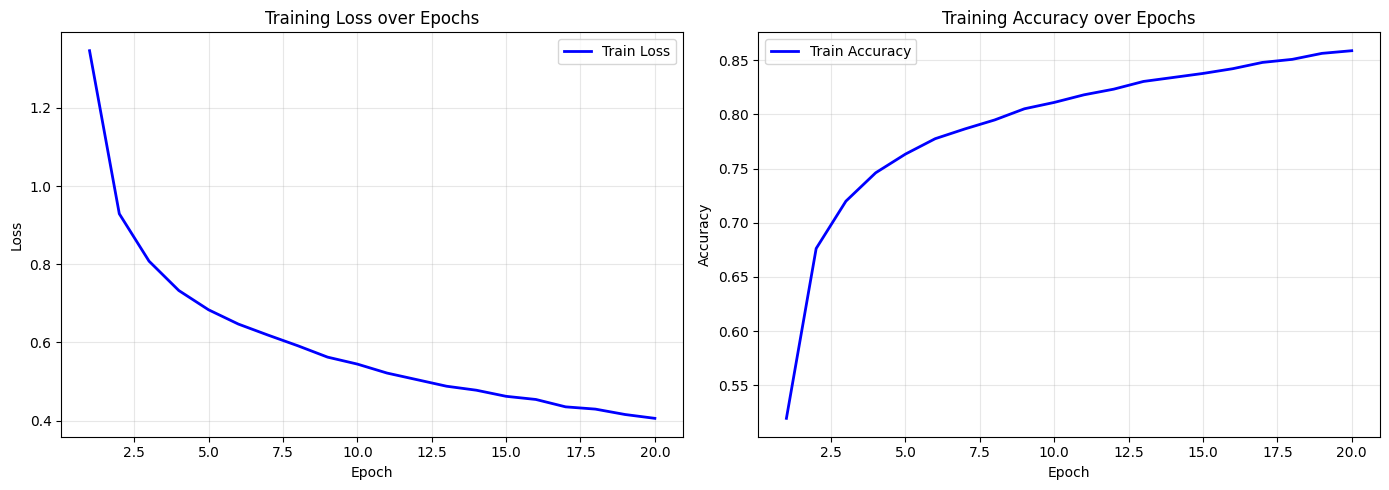

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 215MB/s]
2025-11-19 08:55:55,895 - INFO - Created ResNet18 with 10 output classes
2025-11-19 08:55:55,912 - INFO - With frozen learning for ResNet18
2025-11-19 08:55:55,914 - INFO - Error function: CrossEntropyLoss()
2025-11-19 08:55:55,916 - INFO - Optimizer: AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: True
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 1e-05
    maximize: False
    weight_decay: 0.0001
)
2025-11-19 08:56:51,912 - INFO - Epoch 1/20 Train Loss: 2.4790, Train Acc: 0.1128
2025-11-19 08:57:46,383 - INFO - Epoch 2/20 Train Loss: 2.3677, Train Acc: 0.1386
2025-11-19 08:58:40,829 - INFO - Epoch 3/20 Train Loss: 2.2961, Train Acc: 0.1642
2025-11-19 08:59:35,698 - INFO - Epoch 4/20 Train Loss: 2.2347, Train Acc: 0.1872
2025-11-19 09:00:31,292 - INFO - Epoch 5/20 Train Loss: 2.1936, Train Acc: 0.2042
2025-11-19 09:01:28,259 - 

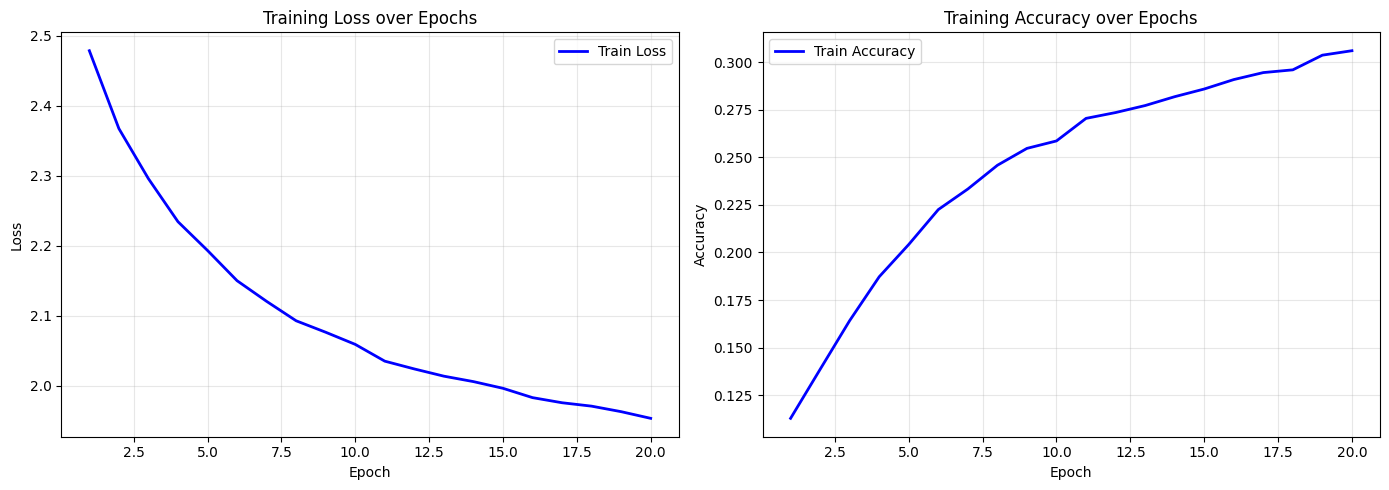

2025-11-19 09:14:49,086 - INFO - Created ResNet18 with 10 output classes
2025-11-19 09:14:49,105 - INFO - Without frozen learning for ResNet18
2025-11-19 09:14:49,107 - INFO - Error function: CrossEntropyLoss()
2025-11-19 09:14:49,108 - INFO - Optimizer: AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: True
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 1e-05
    maximize: False
    weight_decay: 0.0001
)
2025-11-19 09:15:51,410 - INFO - Epoch 1/20 Train Loss: 2.0331, Train Acc: 0.2776
2025-11-19 09:16:52,497 - INFO - Epoch 2/20 Train Loss: 1.5417, Train Acc: 0.4524
2025-11-19 09:17:53,822 - INFO - Epoch 3/20 Train Loss: 1.3632, Train Acc: 0.5187
2025-11-19 09:18:57,100 - INFO - Epoch 4/20 Train Loss: 1.2572, Train Acc: 0.5564
2025-11-19 09:19:58,546 - INFO - Epoch 5/20 Train Loss: 1.1801, Train Acc: 0.5839
2025-11-19 09:20:59,874 - INFO - Epoch 6/20 Train Loss: 1.1200, Train Acc: 

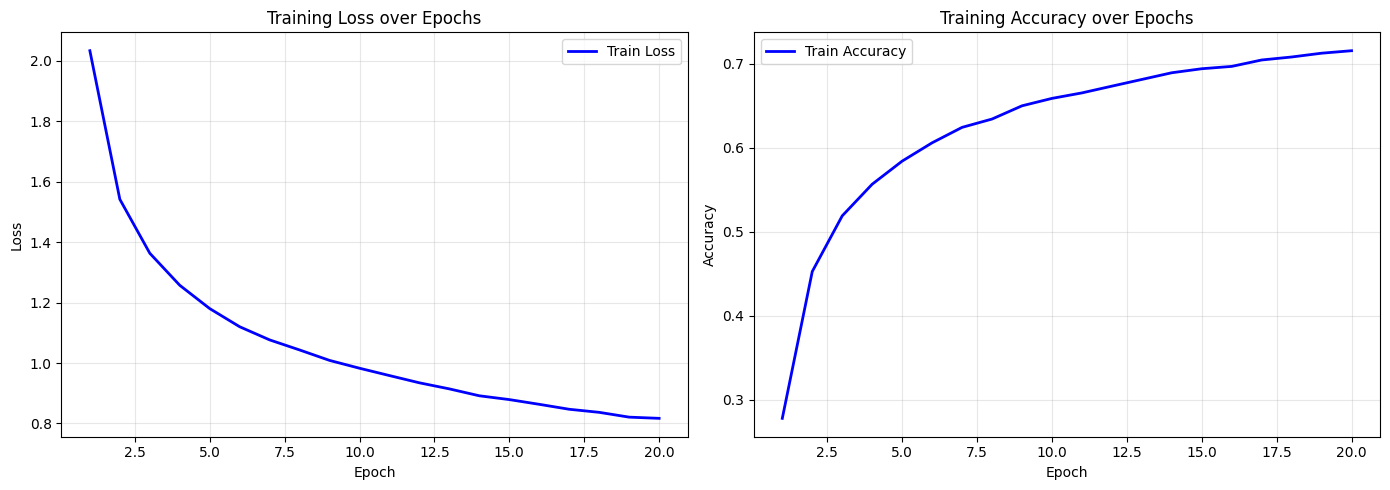

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 226MB/s]
2025-11-19 09:35:35,605 - INFO - Created DenseNet121 with 10 output classes
2025-11-19 09:35:35,634 - INFO - With frozen learning for DenseNet121
2025-11-19 09:35:35,641 - INFO - Error function: CrossEntropyLoss()
2025-11-19 09:35:35,642 - INFO - Optimizer: AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: True
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 1e-05
    maximize: False
    weight_decay: 0.0001
)
2025-11-19 09:36:46,229 - INFO - Epoch 1/20 Train Loss: 2.3885, Train Acc: 0.1190
2025-11-19 09:37:56,331 - INFO - Epoch 2/20 Train Loss: 2.2974, Train Acc: 0.1541
2025-11-19 09:39:06,209 - INFO - Epoch 3/20 Train Loss: 2.2328, Train Acc: 0.1829
2025-11-19 09:40:14,842 - INFO - Epoch 4/20 Train Loss: 2.1720, Train Acc: 0.2102
2025-11-19 09:41:24,131 - INFO - Epoch 5/20 Train Loss: 2.1224, Train Acc: 0.2349
2025-11-19 09:42:34,

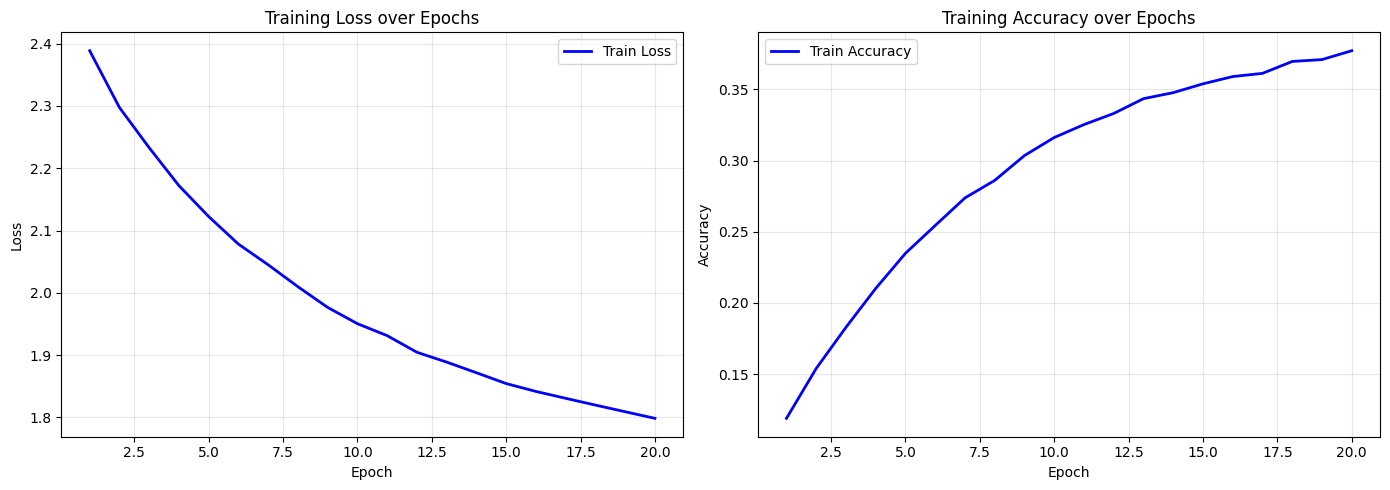

2025-11-19 09:59:00,512 - INFO - Created DenseNet121 with 10 output classes
2025-11-19 09:59:00,545 - INFO - Without frozen learning for DenseNet121
2025-11-19 09:59:00,554 - INFO - Error function: CrossEntropyLoss()
2025-11-19 09:59:00,555 - INFO - Optimizer: AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: True
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 1e-05
    maximize: False
    weight_decay: 0.0001
)
2025-11-19 10:00:42,740 - INFO - Epoch 1/20 Train Loss: 2.1074, Train Acc: 0.2431
2025-11-19 10:02:22,654 - INFO - Epoch 2/20 Train Loss: 1.6055, Train Acc: 0.4388
2025-11-19 10:04:01,053 - INFO - Epoch 3/20 Train Loss: 1.3403, Train Acc: 0.5307
2025-11-19 10:05:39,290 - INFO - Epoch 4/20 Train Loss: 1.1881, Train Acc: 0.5867
2025-11-19 10:07:20,117 - INFO - Epoch 5/20 Train Loss: 1.0926, Train Acc: 0.6160
2025-11-19 10:09:01,442 - INFO - Epoch 6/20 Train Loss: 1.0161, Train

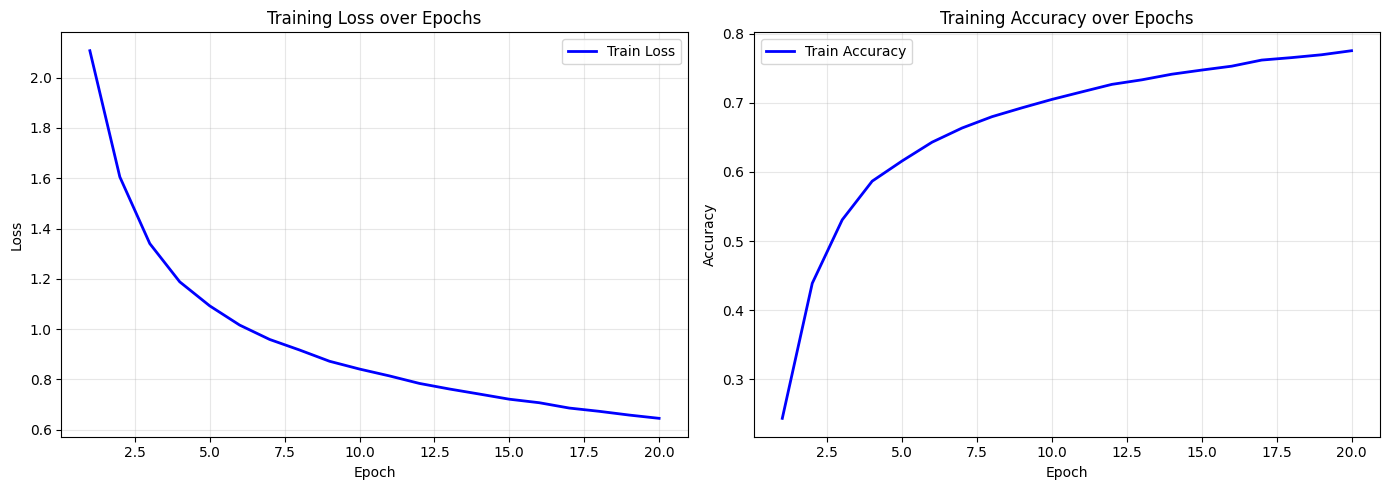

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 184MB/s]
2025-11-19 10:32:20,835 - INFO - Created EfficientNet_B0 with 10 output classes
2025-11-19 10:32:20,853 - INFO - With frozen learning for EfficientNet_B0
2025-11-19 10:32:20,858 - INFO - Error function: CrossEntropyLoss()
2025-11-19 10:32:20,858 - INFO - Optimizer: AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: True
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 1e-05
    maximize: False
    weight_decay: 0.0001
)
2025-11-19 10:33:22,911 - INFO - Epoch 1/20 Train Loss: 2.3951, Train Acc: 0.1096
2025-11-19 10:34:26,240 - INFO - Epoch 2/20 Train Loss: 2.3231, Train Acc: 0.1383
2025-11-19 10:35:28,876 - INFO - Epoch 3/20 Train Loss: 2.2752, Train Acc: 0.1548
2025-11-19 10:36:33,255 - INFO - Epoch 4/20 Train Loss: 2.2281, Train Acc: 0.1817
2025-11-19 10:37:36,628 - INFO - Epoch 5/20 Train Loss: 2.1992, Train Acc: 0.1998
2025-11-19 1

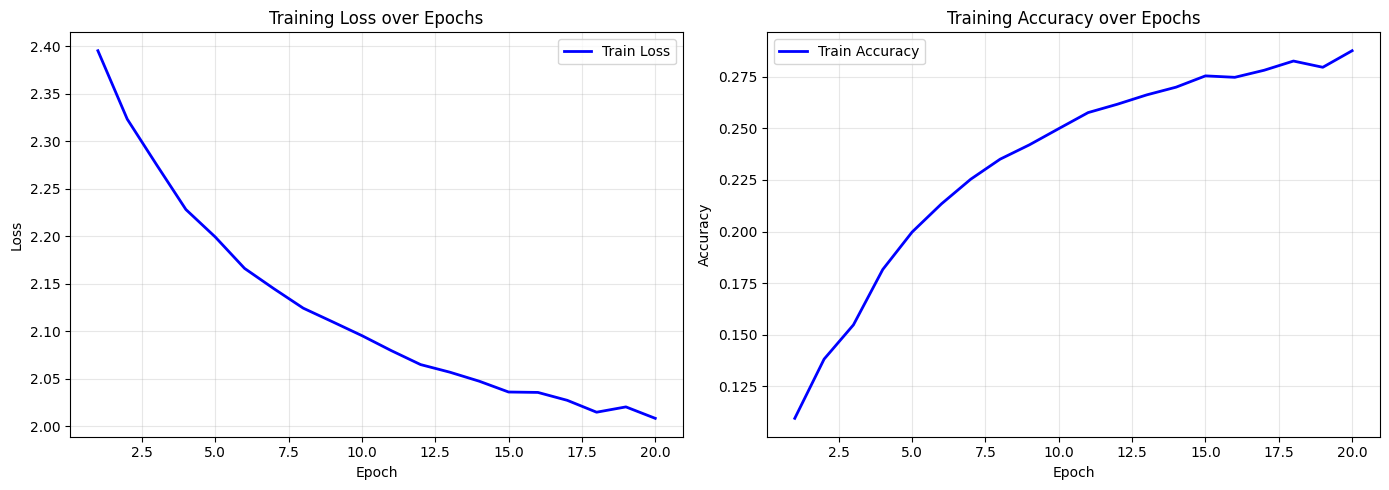

2025-11-19 10:53:40,737 - INFO - Created EfficientNet_B0 with 10 output classes
2025-11-19 10:53:40,755 - INFO - Without frozen learning for EfficientNet_B0
2025-11-19 10:53:40,761 - INFO - Error function: CrossEntropyLoss()
2025-11-19 10:53:40,763 - INFO - Optimizer: AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: True
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 1e-05
    maximize: False
    weight_decay: 0.0001
)
2025-11-19 10:55:00,755 - INFO - Epoch 1/20 Train Loss: 2.3239, Train Acc: 0.1351
2025-11-19 10:56:19,328 - INFO - Epoch 2/20 Train Loss: 2.1583, Train Acc: 0.2193
2025-11-19 10:57:38,867 - INFO - Epoch 3/20 Train Loss: 1.9988, Train Acc: 0.2866
2025-11-19 10:58:59,298 - INFO - Epoch 4/20 Train Loss: 1.8629, Train Acc: 0.3355
2025-11-19 11:00:18,925 - INFO - Epoch 5/20 Train Loss: 1.7565, Train Acc: 0.3736
2025-11-19 11:01:37,985 - INFO - Epoch 6/20 Train Loss: 1.667

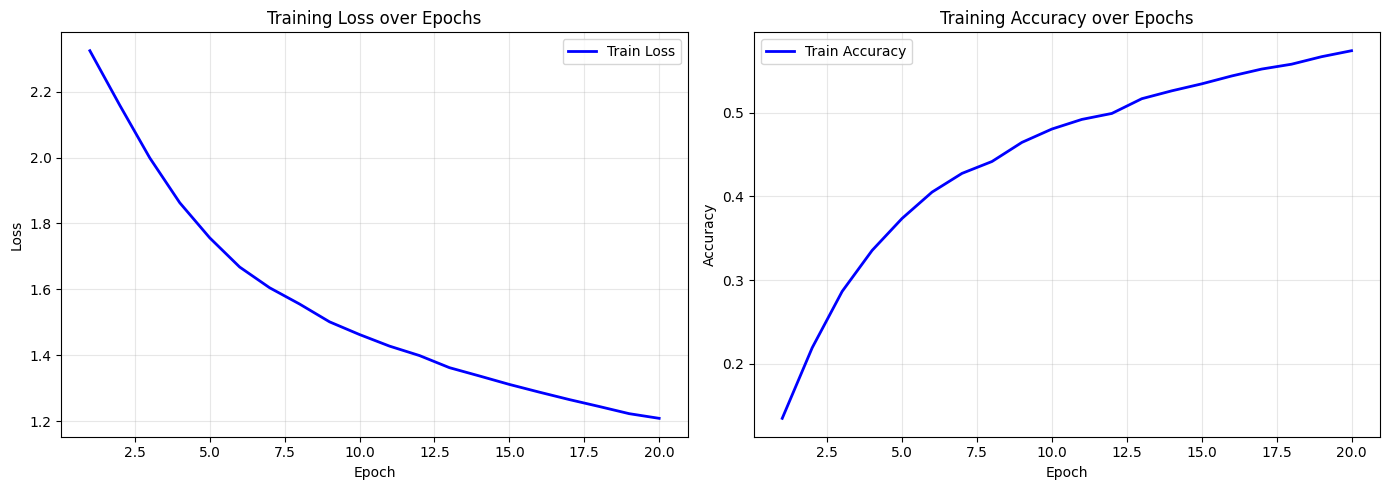

2025-11-19 11:19:47,621 - INFO - Comparison plot saved as 'freeze_compare.png'


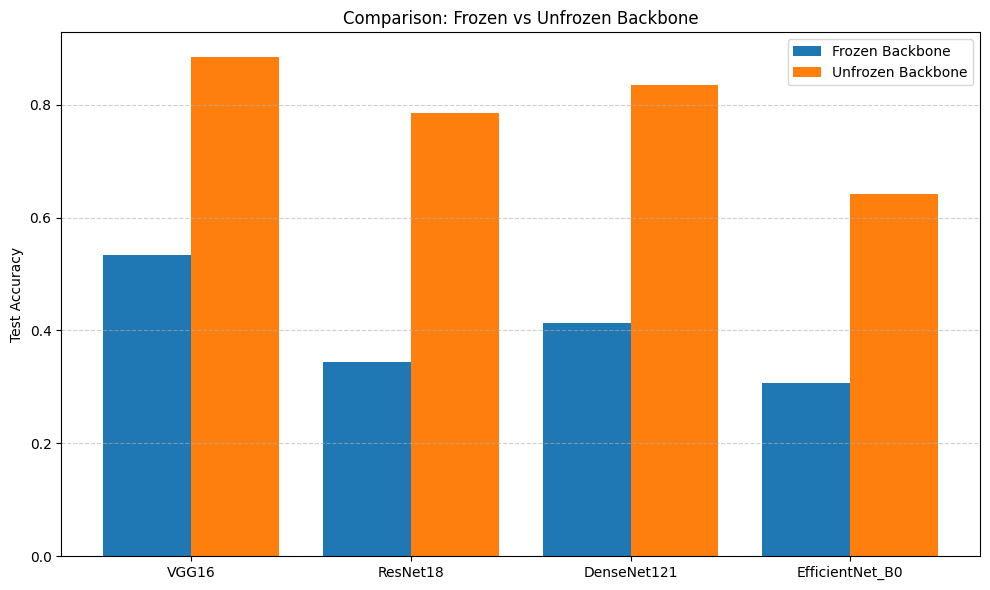

2025-11-19 11:19:47,731 - INFO - Best Model: VGG16
2025-11-19 11:19:47,732 - INFO - Best Test Accuracy: 0.8840
2025-11-19 11:19:47,733 - INFO - Freeze Backbone: False
2025-11-19 11:19:47,733 - INFO - Optimizer: AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: True
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 1e-05
    maximize: False
    weight_decay: 0.0001
)
2025-11-19 11:19:47,734 - INFO - Error function: CrossEntropyLoss()
2025-11-19 11:19:47,735 - INFO - Epochs: 20
2025-11-19 11:19:47,736 - INFO - Best Model saved as 'best_model.pth'
2025-11-19 11:19:47,749 - INFO - 


In [ ]:
if __name__ == "__main__":
    TransferLearningManager(dataset_path).execute_model_comparison(name_model_list, epochs=20)
    logging.info(f"")